# Clasificación con redes bayesianas

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pgmpy.models import BayesianNetwork # para obtener clasificador bayesiano
import bnlearn as bn # esta librería está escrita a partir de pgmpy entonces son compatibles

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from function import (
    create_expert_bucket_numeric_feature,
    get_category_feature,
    plot_categorical_distribution,
    cramers_v,
    apply_threshold,
    precision_recall_curve_plot,
    reporting_metrics
)

In [2]:
datos = pd.read_parquet("student_performance.parquet")

Reemplazo de la variable target

In [3]:
datos['target_num'] = np.where(datos['target'] == "Suspenso", 1, 0)
datos = datos.drop(columns="target")

# Preprocesado de los datos

### Obtención de la muestra de entrenamiento y test

In [4]:
SEED = 123
TEST_SIZE = 0.25

X_train, X_test, y_train, y_test = train_test_split(
    datos.drop(columns="target_num"), datos["target_num"], test_size=TEST_SIZE, random_state=SEED, stratify=datos["target_num"]
)

### Trameado de las variables 

In [5]:
X_train = create_expert_bucket_numeric_feature(X_train, "Absences")
X_train = create_expert_bucket_numeric_feature(X_train, "StudyTimeWeekly")

In [6]:
category_features = [
    'Age', 'Ethnicity', 'ParentalEducation', 
    'ParentalSupport', 'Absences_bucket', 'StudyTimeWeekly_bucket'
]
for col in category_features:
    X_train = get_category_feature(X_train, col)

Para facilitar los análisis de las features con el target se crea un dataframe (X_train, y_train). Además, creamos un dataset de test que utilizaremos posteriormente.

In [7]:
train_data = pd.concat([X_train, y_train], axis=1)
train_data = train_data.drop(columns="StudentID")

test_data = X_test.copy()
test_data = test_data.drop(columns="StudentID")

[datazets] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[datazets] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[datazets] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[datazets] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
[datazets] >INFO> Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the

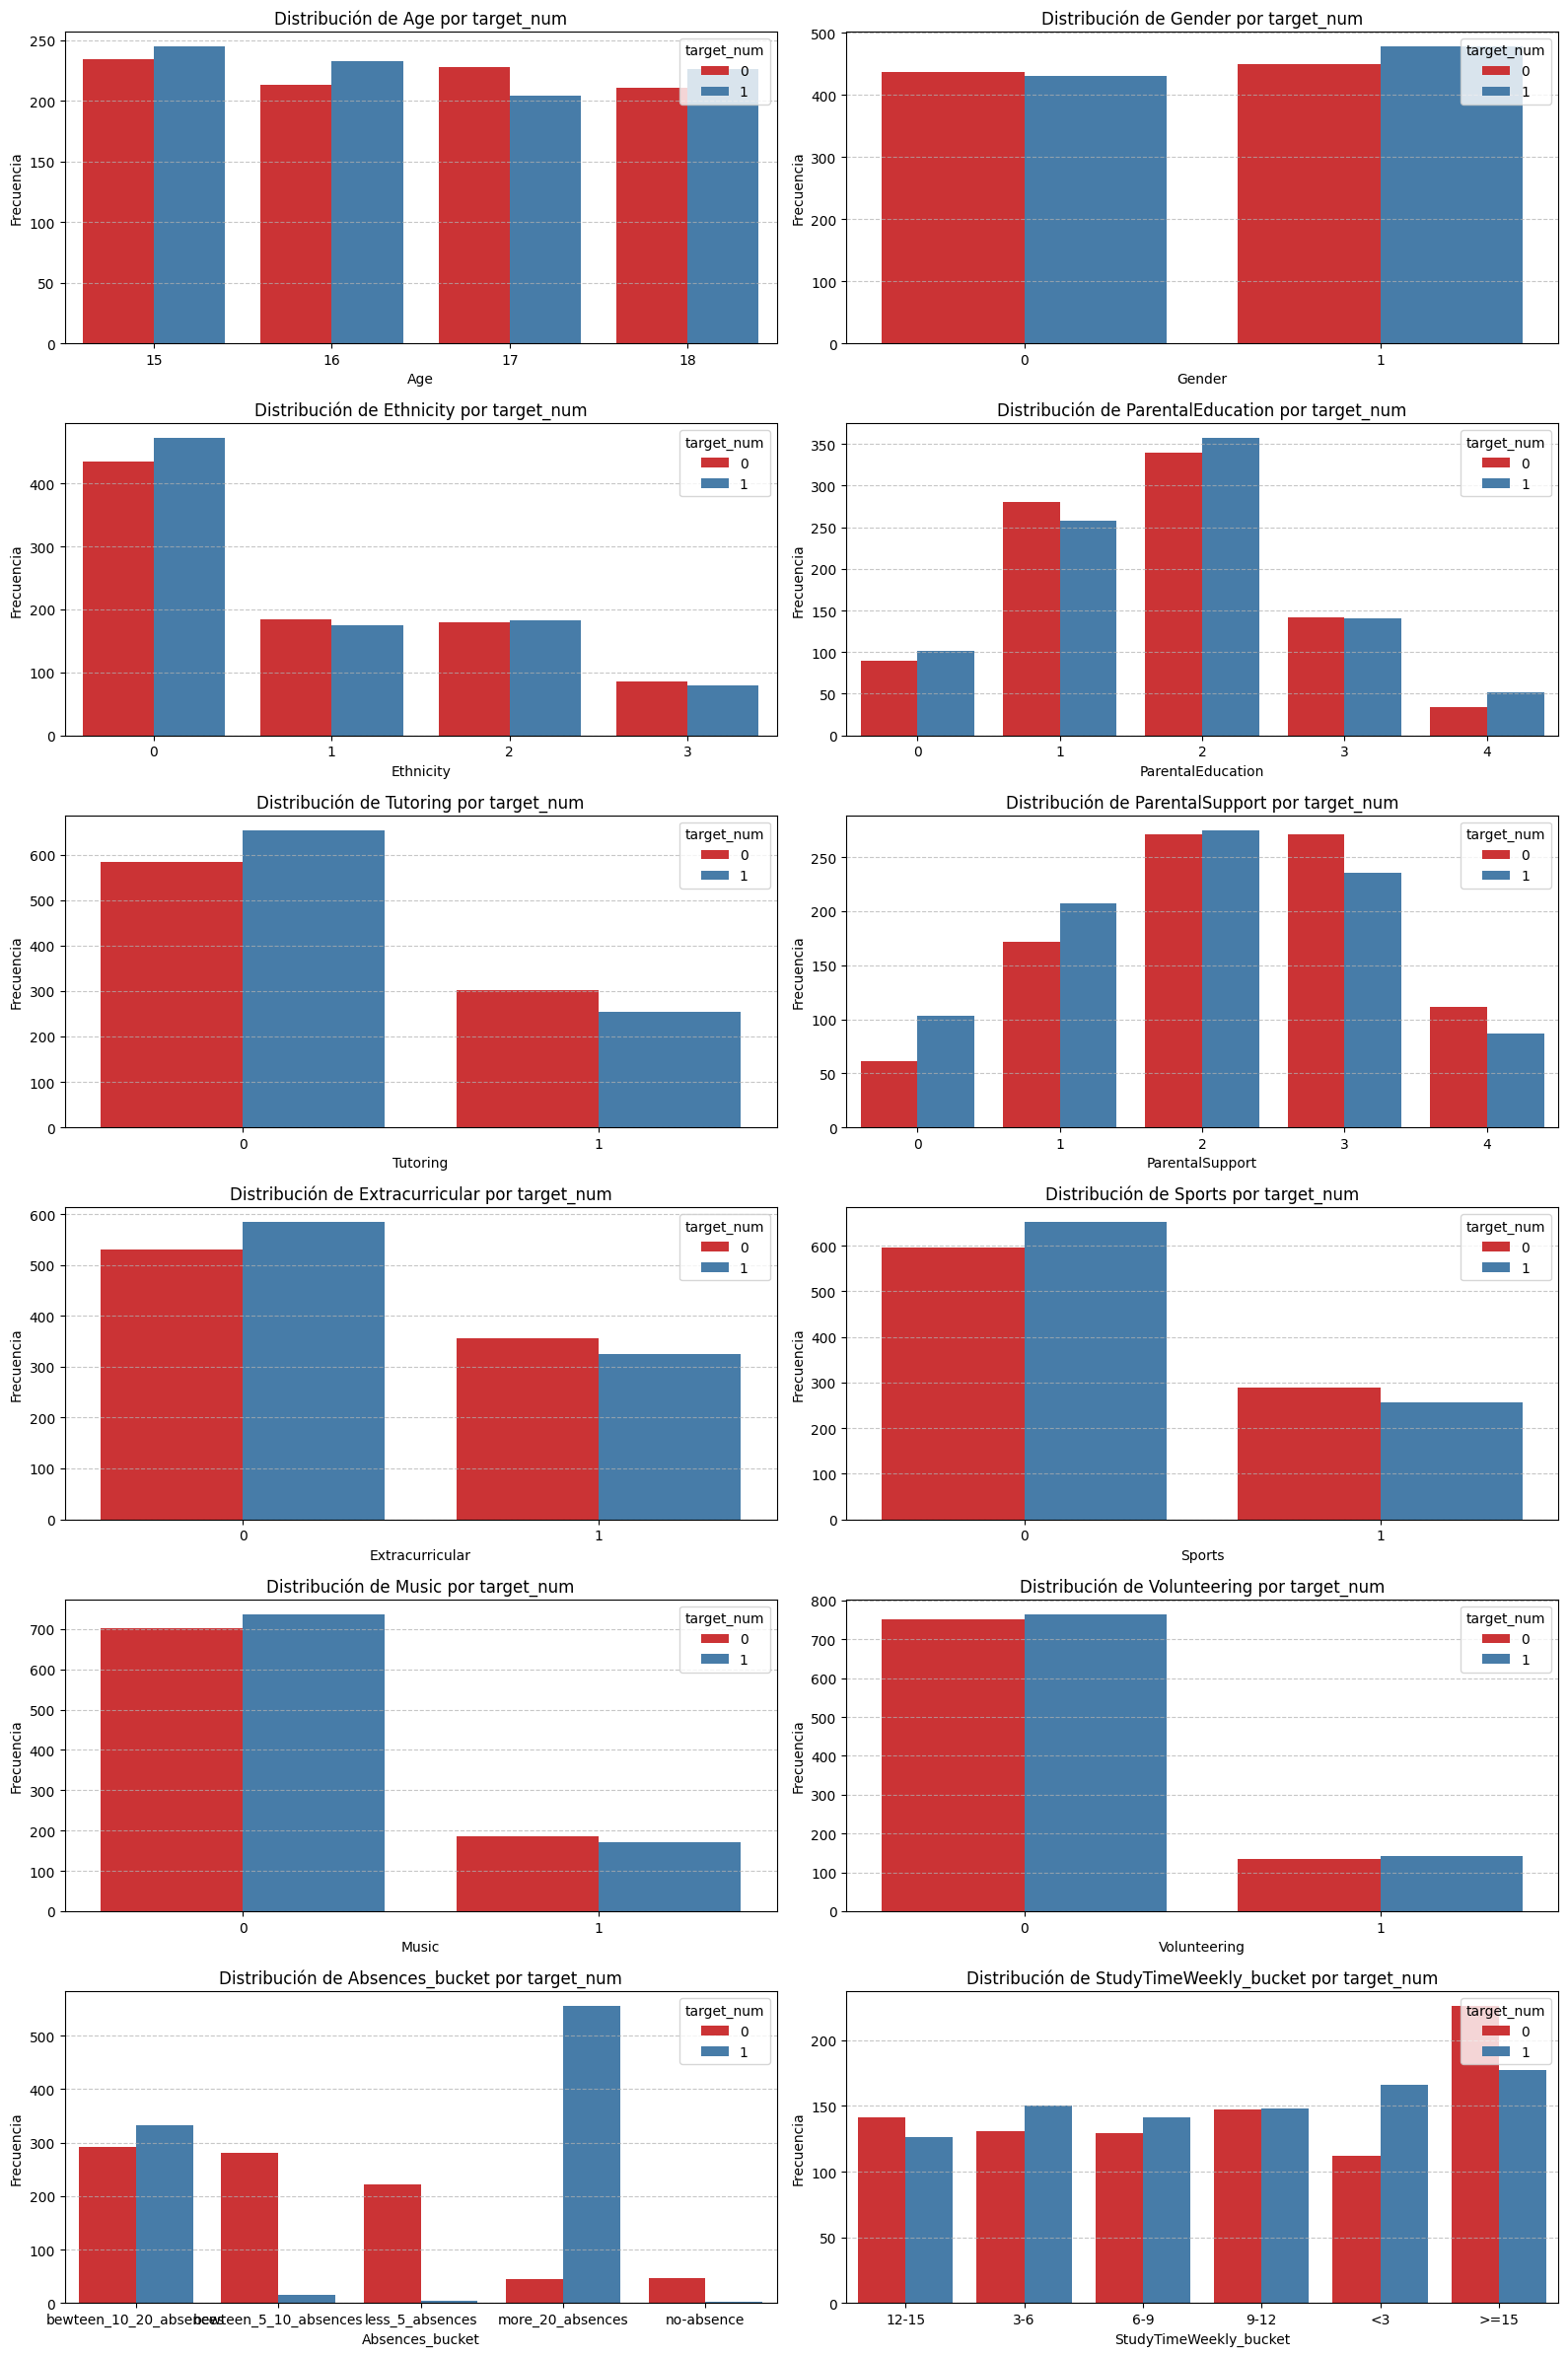

In [8]:
features = train_data.columns[:-1]
num_vars = len(features)
cols = 2
rows = (num_vars + 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(16, 4 * rows))
axes = axes.flatten()

for i, col in enumerate(features):
    plot_categorical_distribution(df=train_data, feature=col, target="target_num", ax=axes[i])

# Ocultar gráficos no utilizados en caso de un número impar de variables
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Como puede verse, existen muchas variables en las que no hay una importante discriminación entre aprobados y suspensos (p.e: "escucha-musica", "hace-voluntariado", "género", "edad").

## Análisis del grado de asociación entre las variables

Para ello, voy a utilizar la V de Cramer. La V de Cramer es una medida de asociación entre dos variables categóricas. Se utiliza para evaluar la fuerza de la relación entre las variables y es una extensión del Chi-cuadrado (tiene en cuenta tanto el tamaño de la muestra como el número de niveles de las dos variables a analizar).

Los valores de V de Cramer pueden variar de 0 a 1, donde:

- 0 indica que no hay asociación entre las variables (son independientes).
- 1 indica una asociación perfecta.

| **Rango de V de Cramer** | **Interpretación**                                                                                           |
|--------------------------|--------------------------------------------------------------------------------------------------------------|
| 0 a 0.1                  | **Muy Débil**: Los valores cercanos a 0 indican una asociación muy débil o nula entre las variables. Esto significa que la relación entre las dos variables es muy tenue o inexistente. |
| 0.1 a 0.3                | **Débil**: Los valores en este rango sugieren una asociación débil. Aunque hay cierta dependencia entre las variables, no es fuerte. |
| 0.3 a 0.5                | **Moderada**: Los valores en este rango indican una asociación moderada. Existe una relación clara entre las variables, pero no es extremadamente fuerte. |
| 0.5 a 0.7                | **Fuerte**: Los valores en este rango sugieren una asociación fuerte. Las variables están claramente relacionadas, y la asociación es considerable. |
| 0.7 a 1                  | **Muy Fuerte**: Los valores cercanos a 1 indican una asociación muy fuerte. Las variables están altamente relacionadas y la dependencia entre ellas es muy clara. |


- Target

In [9]:
cramer_value_target_dict = {}
for col in train_data.columns:
    if col == "target_num":
        continue
    else:
        cramer_value_target_dict[col] = cramers_v(train_data, col, 'target_num')

In [10]:
cramer_value_target_dict

{'Age': 0.03899732842430537,
 'Gender': 0.018540722965934602,
 'Ethnicity': 0.03190054848713912,
 'ParentalEducation': 0.05516989815490683,
 'Tutoring': 0.066078529485648,
 'ParentalSupport': 0.10311734331762346,
 'Extracurricular': 0.04520091516563608,
 'Sports': 0.049303421223204046,
 'Music': 0.025670529948003333,
 'Volunteering': 0.0070722003998746775,
 'Absences_bucket': 0.7182887475769782,
 'StudyTimeWeekly_bucket': 0.10248905639776591}

- Variables explicativas

In [11]:
cramer_value_features_dict = {}
for col_1 in list(train_data.columns)[:-1]:  # No se tiene en cuenta el target
    aux_dict = {}
    for col_2 in list(train_data.columns)[:-1]:
        if col_1 == col_2:
            continue
        else:
            aux_dict[col_2] = cramers_v(train_data, col_1, col_2)
    cramer_value_features_dict[col_1] = aux_dict

# pd.DataFrame(cramer_value_features_dict)

In [12]:
cramer_value_features_dict

{'Age': {'Gender': 0.065549550318568,
  'Ethnicity': 0.042293317035492474,
  'ParentalEducation': 0.04035012489186267,
  'Tutoring': 0.04635080325497153,
  'ParentalSupport': 0.06012575787617309,
  'Extracurricular': 0.04116213740870212,
  'Sports': 0.04887562632688318,
  'Music': 0.036334505927549325,
  'Volunteering': 0.04510194753208746,
  'Absences_bucket': 0.051540131287417246,
  'StudyTimeWeekly_bucket': 0.050527336901183516},
 'Gender': {'Age': 0.065549550318568,
  'Ethnicity': 0.02640376524983783,
  'ParentalEducation': 0.026805873894379613,
  'Tutoring': 0.018350096884423135,
  'ParentalSupport': 0.03227573528274493,
  'Extracurricular': 0.010963833642798378,
  'Sports': 0.0037945524071673594,
  'Music': 0.003221016437036324,
  'Volunteering': 0.008642970930914052,
  'Absences_bucket': 0.03200614073850516,
  'StudyTimeWeekly_bucket': 0.04960971809324307},
 'Ethnicity': {'Age': 0.042293317035492474,
  'Gender': 0.02640376524983783,
  'ParentalEducation': 0.057739828587156705,
 

In [13]:
VCRAMER_THRESHOLD = 0.1
features_dict = {}
for col_1, item in cramer_value_features_dict.items():
    aux_feats_list = []
    for col_2, values in item.items():
        if values > VCRAMER_THRESHOLD:
            aux_feats_list.append(col_2)
    features_dict[col_1] = aux_feats_list

In [14]:
features_dict

{'Age': [],
 'Gender': [],
 'Ethnicity': [],
 'ParentalEducation': [],
 'Tutoring': [],
 'ParentalSupport': [],
 'Extracurricular': [],
 'Sports': [],
 'Music': [],
 'Volunteering': [],
 'Absences_bucket': [],
 'StudyTimeWeekly_bucket': []}

Como podemos ver, no existe apenas asociación entre las variables explicativas. A su vez, según indica el valor de la V de Cramer, también existe un bajo grado de asociación entre las features y el target. Así, vamos a usar el umbral de 0.10 como selector de características.
- Hijos: study-timeweekly-bucket, absences-bucket, parental-support
- Padre: target

In [15]:
features_son = ["StudyTimeWeekly_bucket", "Absences_bucket", "ParentalSupport"]
columns_bayesian_netorks = features_son + ["target_num"] 

In [16]:
X_train = X_train[features_son]

In [17]:
train_data = train_data[columns_bayesian_netorks]

# Red bayesiana (TAN)

## Estructura de la red

Sobre la muestra de entrenamiento, definimos la estrucura de la red TAN

In [18]:
structure_model = bn.structure_learning.fit(train_data, methodtype='tan', root_node="ParentalSupport", class_node="target_num") # uso de hill-climbing

[bnlearn] >Computing best DAG using [tan]


Building tree:   0%|          | 0/6.0 [00:00<?, ?it/s]

[bnlearn] >Compute structure scores for model comparison (higher is better).


Una vez construido el DAG pueden verse los bordes tanto de forma tabular como gráfica.

In [19]:
pd.DataFrame(structure_model['model_edges'], columns=["parent", "son"])

,parent,son
0,ParentalSupport,Absences_bucket
1,Absences_bucket,StudyTimeWeekly_bucket
2,target_num,StudyTimeWeekly_bucket
3,target_num,Absences_bucket
4,target_num,ParentalSupport


Como puede verse, las variables `target-num` y `parental-support` son las únicas que no tienen ascendente.

[bnlearn] >Set node properties.
[bnlearn] >Set edge properties.
[bnlearn] >Plot based on Bayesian model


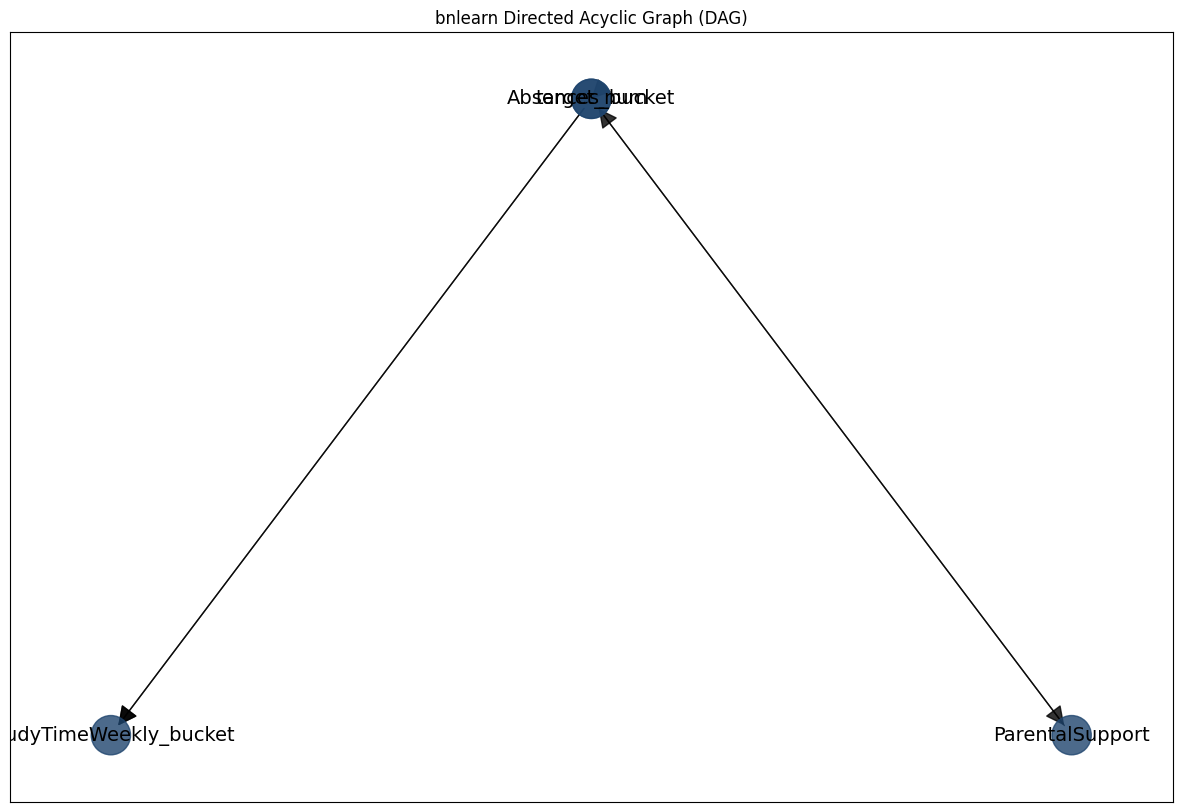

In [20]:
bn.plot(structure_model)
plt.show()

## Parámetros de la red

A partir de la estructura definida previamente, se ajusta el modelo para aprender sus parámetros. Y a partir de ahí obtenemos las probabilidades condicionadas.

In [21]:
parameter_model = bn.parameter_learning.fit(structure_model, train_data, methodtype='bayes', verbose=0)

In [22]:
CPDs = bn.print_CPD(parameter_model, verbose=0) # probabilidades condicionadas

A partir del objeto *CPDs* se puede obtener la probabilidad condicionada a priori como:

In [23]:
CPDs["target_num"]

,target_num,p
0,0,0.496063
1,1,0.503937


Es importante destacar que las probabilidad condicionada a priori no es exactamente la frecuencia absoluta de los datos porque se está empleando el **suavizado de Laplace**. Este suavizado ajusta ligeramente las probabilidades para evitar probabilidades de cero, especialmente en casos con pocas observaciones 

In [24]:
train_data["target_num"].value_counts(normalize=True)

target_num
1    0.506132
0    0.493868
Name: proportion, dtype: float64

In [25]:
CPDs["Absences_bucket"]

,Absences_bucket,ParentalSupport,target_num,p
0,bewteen_10_20_absences,0,0,0.198758
1,bewteen_10_20_absences,0,1,0.280788
2,bewteen_10_20_absences,1,0,0.224265
3,bewteen_10_20_absences,1,1,0.368078
4,bewteen_10_20_absences,2,0,0.269542
5,bewteen_10_20_absences,2,1,0.309333
6,bewteen_10_20_absences,3,0,0.347709
7,bewteen_10_20_absences,3,1,0.300595
8,bewteen_10_20_absences,4,0,0.331754
9,bewteen_10_20_absences,4,1,0.240642


Si de la tabla anterior nos focalizamos en aquellos estudiantes que no tienen apoyo de sus padres tenemos:

In [26]:
p = CPDs["Absences_bucket"][CPDs["Absences_bucket"]["ParentalSupport"] == 0]

Siendo entonces la probabildiad condicional para cada clase:

- Suspenso

In [27]:
p[p["target_num"] == 1].sort_values(by="p") # ordenadas por probabilidad

,Absences_bucket,ParentalSupport,target_num,p
21,less_5_absences,0,1,0.103448
41,no-absence,0,1,0.103448
11,bewteen_5_10_absences,0,1,0.113300
1,bewteen_10_20_absences,0,1,0.280788
31,more_20_absences,0,1,0.399015


- Aprobados

In [28]:
p[p["target_num"] == 0].sort_values(by="p") # ordenadas por probabilidad

,Absences_bucket,ParentalSupport,target_num,p
30,more_20_absences,0,0,0.142857
40,no-absence,0,0,0.149068
0,bewteen_10_20_absences,0,0,0.198758
20,less_5_absences,0,0,0.242236
10,bewteen_5_10_absences,0,0,0.267081


También podríamos hacer inferencia. A continuación, una posible cuestión:

- *Teniendo en cuenta el modelo construido, ¿con qué probabilidad suspende un alumno que estudia más de 15h semanales y tiene menos de 5 ausencias durante el curso? P(calificacion | tiempo_estudio>=15, ausencia<5)*

In [29]:
output = bn.inference.fit(
    parameter_model,
    variables=['target_num'],
    evidence={'StudyTimeWeekly_bucket': '>=15', 'Absences_bucket':'less_5_absences'},
    verbose=0
)

output.df

,target_num,p
0,0,0.792531
1,1,0.207469


Así, la probabilidad de suspenso es solo de un 20%. 

# Clasificador bayesiano: modelo TAN

In [30]:
model = BayesianNetwork(parameter_model["model_edges"]) # incluimos el modelo gráfico obtenido anteriormente
model.fit(train_data) # train_data contiene tanto el feature como el target
# predicciones muestra entrenamiento

pred_proba_train_df = model.predict_probability(X_train) # X_train es igual que train_data pero sin incluir el target 

Una vez tenemos las probabilidades del modelo, planteamos diferentes umbrales para tomar la decisión.

In [31]:
threshold_list = [0.35, 0.40, 0.45, 0.50, 0.55, 0.60] 

Para cada nivel de threshold, ahora obtenemos la clase predicha. Se crea un dataframe para ello usando la función `apply_threshold` conjuntamente con apply.

In [32]:
pred_proba_train = pred_proba_train_df["target_num_1"]
pred_proba_train.name = "probabilidad"
pred_proba_df = pred_proba_train.to_frame()

# Crear un DataFrame con las predicciones para cada threshold
y_train_pred = pd.DataFrame({
    f'prediction_threshold_{value}': pred_proba_df['probabilidad'].apply(apply_threshold, threshold=value)
    for value in threshold_list
})

y_train_pred = pd.concat(
    [pred_proba_df.reset_index(drop=True), y_train_pred.reset_index(drop=True), y_train.reset_index(drop=True)], 
    axis=1
)
# reset-index es porque la concatenación se hace por índice y no todas las df o series tienen el mismo

Obtenemos para cada nivel de threshold la matriz de confusión, la precisión y el recall:

In [33]:
precision_list = []
recall_list = []
for col in y_train_pred.columns[:-1]: # eliminamos el target
    if col == "probabilidad":
        continue
    else:
        print(col)
        print(confusion_matrix(y_train_pred["target_num"], y_train_pred[col]))
        precision_list.append(precision_score(y_train_pred['target_num'], y_train_pred[col]))
        recall_list.append(recall_score(y_train_pred['target_num'], y_train_pred[col]))
        print("")

prediction_threshold_0.35
[[659 227]
 [ 58 850]]

prediction_threshold_0.4
[[678 208]
 [ 61 847]]

prediction_threshold_0.45
[[695 191]
 [ 74 834]]

prediction_threshold_0.5
[[736 150]
 [112 796]]

prediction_threshold_0.55
[[752 134]
 [124 784]]

prediction_threshold_0.6
[[772 114]
 [174 734]]



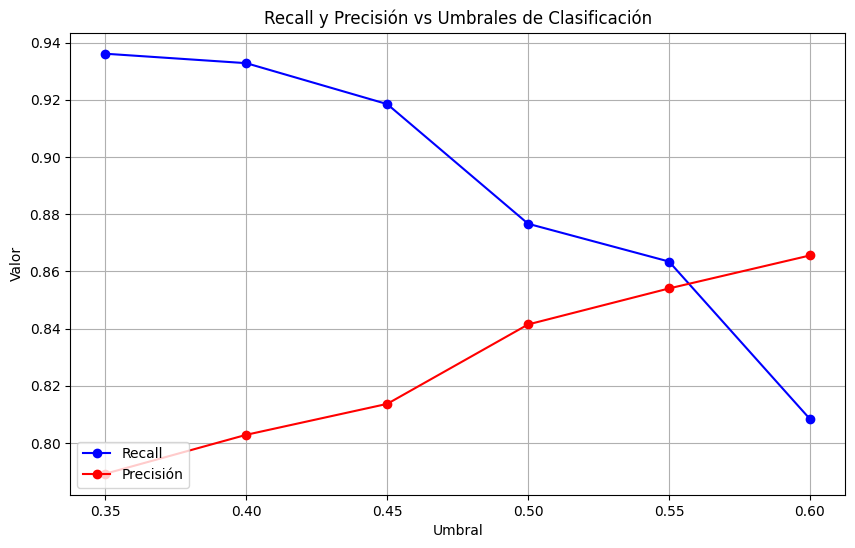

In [34]:
precision_recall_curve_plot(threshold=threshold_list, precision=precision_list, recall=recall_list)

El threshold escogido en este caso es 0.55 puesto que se considera que balancea adecuadamente el ratio de falsos positivos y falsos negativos. 

En este caso, se prioriza cometer un error similar entre los que se consideran aprobados pero realmente son suspensos y viceversa. Esto es así porque, a juicio del modelo que quiere utilizar el examinador:
- Se ayuda a aprobar a los que están suspensos pero cerca de la nota de corte
- Se dispone los recursos necesarios, como tutorías de refuerzo, para los alumnos que tienen un aprendizaje más lento

Una vez tenemos el modelo se hacen predicciones a la muestra de test. Hay que tener en cuenta que:
- Crear bueckets para las variables "Absences" y "StudyTimeWeekly"
- Categorizar las variables
- Analizar que los niveles de las variables sean las mismas
- Definir la muestra con las variables específicas (v-cramer)

In [35]:
X_test = create_expert_bucket_numeric_feature(X_test, "Absences")
X_test = create_expert_bucket_numeric_feature(X_test, "StudyTimeWeekly")

In [36]:
for col in category_features:
    X_test = get_category_feature(X_test, col)

In [37]:
X_test = X_test[features_son] # nos quedamos solo con las variables que tenemos en el clasificador bayesiano

for test_feats, train_feats in zip(X_test.columns, X_train.columns):
    print(f"Column: {test_feats}")
    test_values = list(X_test[test_feats].unique())
    train_values = list(X_test[train_feats].unique())
    for test, train in zip(test_values, train_values):
        print(f"{test} -> {test == train}")
    print("")

Column: StudyTimeWeekly_bucket
12-15 -> True
6-9 -> True
<3 -> True
>=15 -> True
3-6 -> True
9-12 -> True

Column: Absences_bucket
more_20_absences -> True
bewteen_5_10_absences -> True
bewteen_10_20_absences -> True
less_5_absences -> True
no-absence -> True

Column: ParentalSupport
4 -> True
2 -> True
1 -> True
3 -> True
0 -> True



El bucle anterior analiza si los niveles para cada una de las 3 variables en las muestras de train y test son las mismas.

Finalmente, a partir del threshold planteado en la muestra de entrenamiento, se obtienen las predicciones para la muestra de test

In [38]:
THRESHOLD_VALUE = 0.55

# predicciones para muestra test
pred_proba_test_df = model.predict_probability(X_test)
pred_proba_test = pred_proba_test_df["target_num_1"]
pred_proba_test.name = "probabilidad"
pred_proba_test_df = pred_proba_test.to_frame()

y_test_pred = pd.DataFrame({f'prediction_threshold_{THRESHOLD_VALUE}': pred_proba_test_df['probabilidad'].apply(apply_threshold, threshold=THRESHOLD_VALUE)})

A continuación, mostramos la bondad de ajuste del modelo en la muestra de entrenamiento y en la monitorización de los datos de test

In [39]:
reporting_metrics(y_train, y_train_pred[f"prediction_threshold_{THRESHOLD_VALUE}"], "train_data")

train_data

[[752 134]
 [124 784]]
precision: 0.854
recall: 0.8634
f1-score: 0.8587


In [40]:
reporting_metrics(y_test, y_test_pred[f"prediction_threshold_{THRESHOLD_VALUE}"], "test_data")

test_data

[[264  31]
 [ 51 252]]
precision: 0.8905
recall: 0.8317
f1-score: 0.8601


Como podemos ver nuestro modelo evalúa de forma adecuada los registros de la muestra de test; muestra que simula la puesta en producción del modelo.